In [1]:
import json
import torch
from torchvision.transforms import Compose, transforms
import os
import cv2 as cv
import PIL
from PIL import ImageDraw
from utils.data_utils import load_image
from typing import Tuple
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

In [5]:
ROOT_DIR = "C://Users//Hp//Desktop//RBG//STEM_OCR//dataset//training_data"

In [5]:
ROOT_ANNOT_DIR = "C://Users//Hp//Desktop//RBG//STEM_OCR//dataset//training_data//annotations"
max_len = 0
skipped = []
for annot in os.listdir(ROOT_ANNOT_DIR):
    json_path = os.path.join(ROOT_ANNOT_DIR, annot)
    try:
        with open(json_path,"r") as f:
            data = json.load(f)
        max_len = max(max_len, len(data["form"]))
    except:
        skipped.append(json_path)
        continue
    

In [6]:
max_len

181

In [9]:
len(os.listdir(ROOT_ANNOT_DIR))-len(skipped)

130

In [6]:
def normalize_bbox(bbox, size):
    return [
        int(1000 * bbox[0] / size[0]),
        int(1000 * bbox[1] / size[1]),
        int(1000 * bbox[2] / size[0]),
        int(1000 * bbox[3] / size[1]),
    ]

def load_image(image_path):
    image = cv.imread(image_path)
    w, h = image.shape[0], image.shape[1]
    image = torch.tensor(image)
    print(image.shape)
    transform = Compose([transforms.Resize((224,224))])
    img = transform(image.permute(2,0,1))
    print(img.shape)
    return img , (w,h)

In [44]:
class FUNSD(torch.utils.data.Dataset):

    def __init__(self, root_dir):
        self.img_dir_path = os.path.join(root_dir,"images")
        self.annotation_dir_path = os.path.join(root_dir, "annotations")
        self.root_dir = root_dir
        self.img_dir = os.listdir(self.img_dir_path)
        self.annot_dir = os.listdir(self.annotation_dir_path)
        # self.max_annot_len, self.no_of_data = self._check_max()

    def _check_max(self) -> Tuple[int ,int]:
        max_len = 0
        skipped = []
        for annot in os.listdir(self.root_dir):
            json_path = os.path.join(self.root_dir, annot)
            try:
                with open(json_path,"r") as f:
                    data = json.load(f)
                max_len = max(max_len, len(data["form"]))
            except:
                skipped.append(json_path)
                continue
        return max_len, len(os.listdir(self.annot_dir)) - len(skipped)
    

    def get_line_bbox(self, bboxs):
        x = [bboxs[i][j] for i in range(len(bboxs)) for j in range(0, len(bboxs[i]), 2)]
        y = [bboxs[i][j] for i in range(len(bboxs)) for j in range(1, len(bboxs[i]), 2)]

        x0, y0, x1, y1 = min(x), min(y), max(x), max(y)

        assert x1 >= x0 and y1 >= y0
        bbox = [[x0, y0, x1, y1] for _ in range(len(bboxs))]
        return bbox
    
    
    def __len__(self):
        return len(self.img_dir)
    
    def __getitem__(self, idx):
        image_path = self.img_dir_path + "//" + f"{self.img_dir[idx]}"
        annotation = self.annotation_dir_path + "//" + f"{self.annot_dir[idx]}"
        tokens = []
        bboxes = []
        boxes = []
        ner_tags = []
        with open(annotation, "r", encoding="utf8") as f:
            data = json.load(f)
        # image_path = os.path.join(img_dir, file)
        # image_path = image_path.replace("json", "png")
        image, size = load_image(image_path)
        for item in data["form"]:
            cur_line_bboxes = []
            words, label = item["words"], item["label"]
            words = [w for w in words if w["text"].strip() != ""]
            if len(words) == 0:
                continue
            if label == "other":
                for w in words:
                    tokens.append(w["text"])
                    ner_tags.append("O")
                    boxes.append(w["box"])
                    cur_line_bboxes.append(normalize_bbox(w["box"], size))
            else:
                tokens.append(words[0]["text"])
                ner_tags.append("B-" + label.upper())
                boxes.append(w["box"])
                cur_line_bboxes.append(normalize_bbox(words[0]["box"], size))
                for w in words[1:]:
                    tokens.append(w["text"])
                    ner_tags.append("I-" + label.upper())
                    boxes.append(w["box"])
                    cur_line_bboxes.append(normalize_bbox(w["box"], size))
            # by default: --segment_level_layout 1
            # if do not want to use segment_level_layout, comment the following line
            cur_line_bboxes = self.get_line_bbox(cur_line_bboxes)
            # box = normalize_bbox(item["box"], size)
            # cur_line_bboxes = [box for _ in range(len(words))]
            bboxes.extend(cur_line_bboxes)
        return {"tokens": tokens, "bboxes": bboxes, "ner_tags": ner_tags,
                         "image": image, "image_path": image_path, "boxes" : torch.tensor(boxes)}

In [45]:
dataset = FUNSD(ROOT_DIR)

In [46]:
temp = None
for i in dataset:
    temp = i
    break

torch.Size([1000, 762, 3])
torch.Size([3, 224, 224])


In [25]:
temp["image_path"]

'C://Users//Hp//Desktop//RBG//STEM_OCR//dataset//training_data\\images//0000971160.png'

In [24]:
len(temp["boxes"])

145

In [26]:
img = PIL.Image.open('C://Users//Hp//Desktop//RBG//STEM_OCR//dataset//training_data\\images//0000971160.png')

In [30]:
draw = ImageDraw.Draw(img)

In [31]:
for bbox in temp["boxes"]:
    draw.rectangle(bbox)

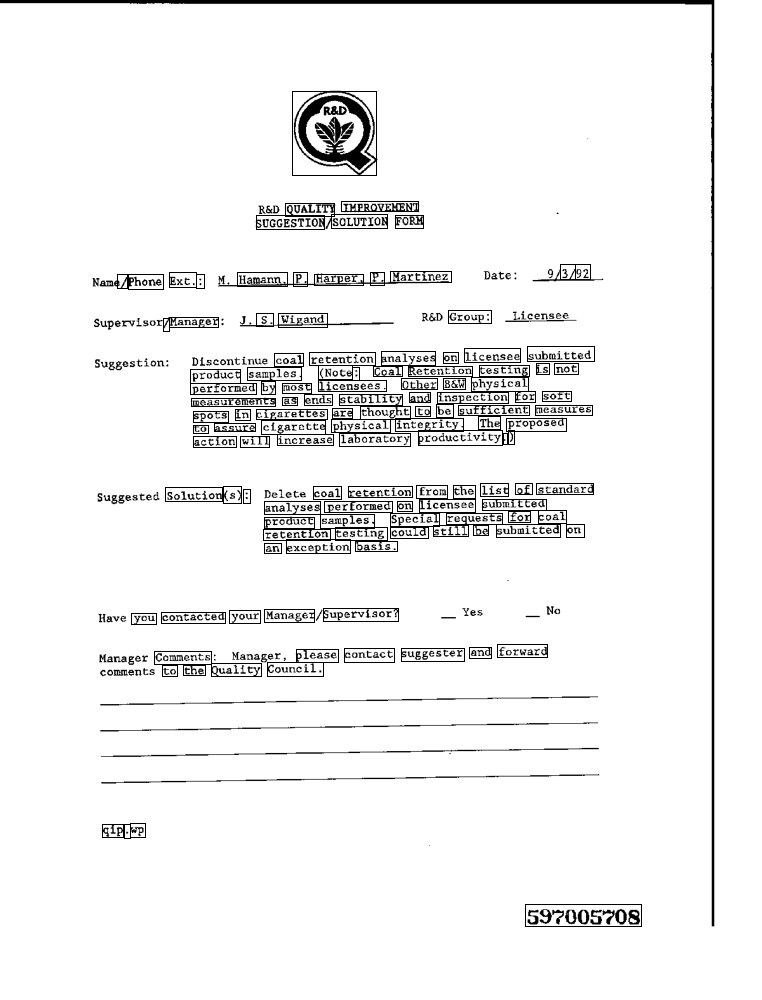

In [32]:
img

**MODEL UTILS**

In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size)
        self.patch_shape = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.num_patches_w = self.patch_shape[0]
        self.num_patches_h = self.patch_shape[1]

    def forward(self, x, position_embedding=None):
        x = self.proj(x)

        if position_embedding is not None:
            position_embedding = position_embedding.view(1, self.patch_shape[0], self.patch_shape[1], -1).permute(0, 3, 1, 2)
            Hp, Wp = x.shape[2], x.shape[3]
            position_embedding = F.interpolate(position_embedding, size=(Hp, Wp), mode='bicubic')
            x = x + position_embedding

        x = x.flatten(2).transpose(1, 2)
        return x

In [35]:
patches  = PatchEmbed(embed_dim=16)

In [38]:
result = patches(temp["image"].float())

In [39]:
result.shape

torch.Size([16, 14, 14])

In [61]:
class BBPositionalEncoding(nn.Module):

    def __init__(self,max_size, embedding_dim):
        super(BBPositionalEncoding,self).__init__()
        self.max_size = max_size
        self.embedding_dim = embedding_dim
        pe = torch.zeros(max_size, embedding_dim)
        position = torch.arange(0, max_size, dtype = torch.float).unsqueeze(1)
        div_freq = torch.exp(torch.arange(0,embedding_dim,2).float() * -(math.log(10000.0) / embedding_dim))
        pe[:, 0::2] = torch.sin(position * div_freq)
        pe[:, 1::2] = torch.cos(position * div_freq)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:,:x.unsqueeze(0).size(1), :].detach()

class BoundingBoxSpatialEmbeddingModel(nn.Module):
    def __init__(self, embedding_dim, max_len=145):
        super(BoundingBoxSpatialEmbeddingModel, self).__init__()
        self.max_len = max_len
        self.positional_encoding = BBPositionalEncoding(max_len, embedding_dim)
        self.embedding_layer = nn.Linear(4, embedding_dim)  
        self.spatial_embedding_layer = nn.Linear(embedding_dim, embedding_dim)
    
    def aux_get_positional_encoding(self):
        return self.positional_encoding.pe

    def forward(self, bounding_boxes):
        embeddings = self.embedding_layer(bounding_boxes.float())
        positional_encoded_boxes = self.positional_encoding(embeddings)
        spatial_embeddings = self.spatial_embedding_layer(positional_encoded_boxes)

        return spatial_embeddings

In [62]:
data = BoundingBoxSpatialEmbeddingModel(24)

In [64]:
box_embedding = data(temp["boxes"])

In [66]:
box_embedding.shape

torch.Size([1, 145, 24])

In [39]:
pe = data.aux_get_positional_encoding()

In [41]:
pe.shape

torch.Size([1, 145, 24])

In [42]:
pe.size(1)

145

In [51]:
temp["boxes"].unsqueeze(0).size(1)

145

In [57]:
pe[ :, :temp["boxes"].unsqueeze(0).size(1), :].shape

torch.Size([1, 145, 24])

**Attention**

In [70]:
no_of_heads = 4
head_dim = int(48/4)
all_dim = no_of_heads * head_dim

In [69]:
query = nn.Linear(24,48)
key = nn.Linear(24,48)
value = nn.Linear(24, 48)

In [68]:
def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)